<function imatrix_rand at 0x7f6975d469d8>
Summary statistics for IMatrix: [[1 1 0 0 1 0]
 [0 1 1 0 1 0]
 [0 0 1 1 1 0]
 [0 0 1 1 1 0]
 [1 0 0 0 1 1]
 [1 0 0 0 1 1]] K=2
average number of peaks: 3.465
maximum number of peaks: 10.0
minimum number of peaks: 1.0
average maximum value: 0.7421634026544336
average minimum value: 0.2581151985513096
time: 3.64 sec


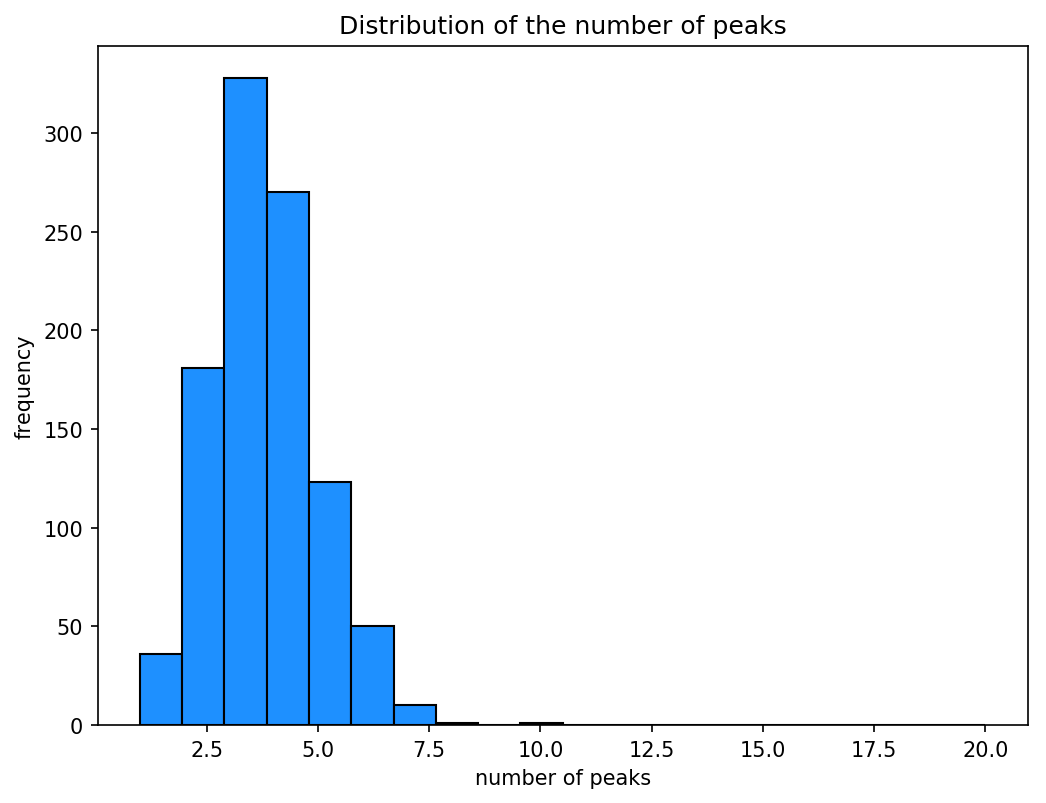

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 15 19:45:19 2020

@author: mrkoujan
"""

import numpy as np
import itertools
import os
from time import time
import matplotlib.pyplot as plt
import random

''' Genel Gidisat:
1)Random interaction matrix generation( rastgele etkilesim matrisi olusturma)


'''

start= time()

# NK landscape parameters -----------------------------------------
N = 6  # number of detailed decisions per lower level landscape   |
i = 1000  # we will generate 1000 NK landscapes to begin with  
K = 2

########################### GENERATING INTERACTION MATRICES 
## This function takes the number of N elements and K interdependencies and creates a random interaction matrix.


''' imatrix_rand diye define etmeye basliyor, kullandigi return ettigi Int_matrix_rand
aa1in her biri icin list seciyor bu listden aa1i kaldirip random karistirip aa1i sonuna geri ekliyor
Chosen_ones dedigi sonuna aa1i de eklediginin son K+1 tanesini aliyor
Chosen oneslar arasindan(sonuncusu her sayi ve diger etkilesimde oldulari K tanesi). 
Int_matrix_rand  satiri aa1 sutunu aa2'lerin her biri olan !!! for demis her biri olarak dusuneceksin biri degil sadece (kendisi de dahil) int +1 diyeceksin


Birseyi tekrarli goturecegin zaman for (i in 1:n){ direk for aa1 in np.arange(N) np.arange N bunun 0dan N-1e kadar N tane yapilacagini soyler


'''
def imatrix_rand():
    Int_matrix_rand = np.zeros((N, N))      #  NxNlik bos matrix
    for aa1 in np.arange(N):                # 0dan N-1 e bir dizilim var. aa1ler teker teker bu dizilimler. for`la baslamis demek ki N 
        Indexes_1 = list(range(N))          
        Indexes_1.remove(aa1)  # remove self
        np.random.shuffle(Indexes_1)
        Indexes_1.append(aa1)
        Chosen_ones = Indexes_1[-(K+1):]  # this takes the last K+1 indexes
        for aa2 in Chosen_ones:
            Int_matrix_rand[aa1, aa2] = 1  # we turn on the interactions with K other variables
    return(Int_matrix_rand)
  
print(imatrix_rand)    


############             NK GENERATING FUNCTIONS

def calc_fit(NK_land_, inter_m, Current_position, Power_key_):  
    '''
    
    Takes the landscape and a given combination and returns a vector of fitness
    values for the vector of the N decision variables. 
    
    '''
    Fit_vector = np.zeros(N) #'0`lardan olusan N uzunlugunda vector'
    for ad1 in np.arange(N): #'0`dan N-1`e kadar sayilarla N tanelik vector ad1'
        Fit_vector[ad1] = NK_land_[np.sum(Current_position * inter_m[ad1]  #'Fit vectorun teker teker pozisyonlarini tanimliyor'
                                          * Power_key_), ad1]
    return(Fit_vector)


def comb_and_values(NK_land_, Power_key_, inter_m):
    '''
    Calculates values for all combinations on the landscape. The resulting
    array contains:
    - the first columns indexed from 0 to N-1 are for each of the combinations
    - columns indexed from N to 2*N-1 are for the fit value (vector) of those combinations
    - the column indexed 2N is for the total fit (average of the entire vector)
    - column indexed 2N+1 is a dummy, with 1 indicating a local peak
    - the last column is a dummy, with 1 indicating the global peak
    '''
    Comb_and_value = np.zeros((2**N, N*2+3))  # to capture the results
    c1 = 0  # starting counter for location
    for c2 in itertools.product(range(2), repeat=N):
        # this takes time so be carefull with landscapes of bigger size
        Combination1 = np.array(c2)  # taking each combination
        fit_1 = calc_fit(NK_land_, inter_m, Combination1, Power_key_)
        Comb_and_value[c1, :N] = Combination1  # combination and values   #once teker teker combinationlari yazdin
        Comb_and_value[c1, N:2*N] = fit_1                                 # sonra bu combinationlarin her biri icin ontributionlari yazdin her locus icin
        Comb_and_value[c1, 2*N] = np.mean(fit_1)                    #2*N yere de bu contributionlarin meanini alip da yazdin
        c1 = c1 + 1                                                 #sonra c1 artik 0. satirdan 1 sonraki satira gececek
    for c3 in np.arange(2**N):  # now let's see if it is a local peak   #simdi artik local mi global mi peakleri bulmaya geldi sira
        loc_p = 1  # first, assume it is
        for c4 in np.arange(N):  # check the local neighbourhood
            new_comb = Comb_and_value[c3, :N].copy().astype(int)
            new_comb[c4] = abs(new_comb[c4] - 1)
            if ((Comb_and_value[c3, 2*N] <
                 Comb_and_value[np.sum(new_comb*Power_key_), 2*N])):
                loc_p = 0  # if smaller than the neighbour, then it is not peak
        Comb_and_value[c3, 2*N+1] = loc_p
    max_ind = np.argmax(Comb_and_value[:, 2*N])  # comb_and_val icerisindekilerin total fittinin en buyuk oldugu satiri buluyor, tum satirlarin 2N sutununa bak ya da fitness degerinin oldugu sutun
    Comb_and_value[max_ind, 2*N+2] = 1 # o max satirin 2N+2 sutununa yani globalini git ve 1 degerini yapistir. artik locallerin de globallerin de var
    return(Comb_and_value)



# *** GENERATING THE NK LANDSCAPES ******************************************
Power_key = np.power(2, np.arange(N - 1, -1, -1))  # used to find addresses on the landscape
Landscape_data = np.zeros((i, 2**N, N*2+3))  # we prepare an array to receive the data

for i_1 in np.arange(i):
    '''
    Now we create the landscapes
    '''
    Int_matrix = imatrix_rand().astype(int)
    
    
    NK_land = np.random.rand(2**N, N)  # this is a table of random U(0,1) numbers
    # Now it is time to survey the topography of our NK landscape
    Landscape_data[i_1] = comb_and_values(NK_land, Power_key, Int_matrix)


# *** CALCULATING SUMMARY STATISTICS ****************************************
number_of_peaks = np.zeros(i)
max_values = np.zeros(i)
min_values = np.zeros(i)

for i_2 in np.arange(i):
    number_of_peaks[i_2] = np.sum(Landscape_data[i_2, :, 2*N+1])
    max_values[i_2] = np.max(Landscape_data[i_2, :, 2*N])
    min_values[i_2] = np.min(Landscape_data[i_2, :, 2*N])

# Let's print some summary statistics of our sample of NK landscapes
print('Summary statistics for IMatrix: ' + str(Int_matrix) + ' K=' + str(K))
print('average number of peaks: ' + str(np.mean(number_of_peaks)))
print('maximum number of peaks: ' + str(np.max(number_of_peaks)))
print('minimum number of peaks: ' + str(np.min(number_of_peaks)))
print('average maximum value: ' + str(np.mean(max_values)))
print('average minimum value: ' + str(np.mean(min_values)))

# plot histogram of the number of local peaks in our sample
plt.figure(1, facecolor='white', figsize=(8, 6), dpi=150)  # for screens with
#          higher resolution change dpi to 150 or 200. For normal use 75.
plt.hist(number_of_peaks, bins=20, range=(1, 20), color='dodgerblue', edgecolor='black') # adjust if necessary
plt.title('Distribution of the number of peaks', size=12)
plt.xlabel('number of peaks', size=10)
plt.ylabel('frequency', size=10)



# *** SAVING THE LANDSCAPES AS A BINARY FILE FOR FUTURE RETRIEVAL ************

#==============================================================================
# If you are saving files on a Mac, change the double back-slash \\ into a 
# single slash /
#==============================================================================

file_name = os.path.expanduser("~")  # we will save it in your home folder

elapsed_time = time() - start
print('time: ' + str("%.2f" % elapsed_time) + ' sec')

In [58]:
# compute the look-up matrix which stores the indices of the neighbhours of each binary row 
lt = np.array([[i^2**j for j in range(N)] for i in range(2**N) ])

# define the mean fitness value index inside the Landscape_data
fv_idx = N*2
init_idx = np.random.choice(N)
i_idx = 0

# start main loop of the algorithm
while True:
    print('init_idx value at the beginning of the current iteration:', init_idx, 
          '\nfitness value at init_idx:', Landscape_data[i_idx, init_idx, fv_idx],)

    # find the current neighbours of the selected row (s) based on the look-up table lt computed above
    curr_neigh = lt[init_idx, :]

    # find the neighbour which has the maximum fitness value
    mfit = np.max(Landscape_data[i_idx, curr_neigh, fv_idx])

    # find the index of this neighbour with maximum fitness value
    max_idx = curr_neigh[np.where(Landscape_data[i_idx, curr_neigh, fv_idx]==mfit)][0]

    # compare the found max fitness value with the randomly selected row at the beginning
    if(mfit > Landscape_data[i_idx, init_idx, fv_idx]):
        init_idx = max_idx

        print('curr_neigh: ', curr_neigh, '\nmax fitness value found in the neighbourhood: ', mfit,
              '\nindex of this maximum value in the table: ', max_idx, '\nnew initial index: ', init_idx,
             '\n###########################################################\n\n\n')
    else:
        print(' >>> reached local optimum!!')
        break

init_idx value at the beginning of the current iteration: 0 
fitness value at init_idx: 0.5412592069166832
curr_neigh:  [ 1  2  4  8 16 32] 
max fitness value found in the neighbourhood:  0.6364073883354355 
index of this maximum value in the table:  1 
new initial index:  1 
###########################################################



init_idx value at the beginning of the current iteration: 1 
fitness value at init_idx: 0.6364073883354355
curr_neigh:  [ 0  3  5  9 17 33] 
max fitness value found in the neighbourhood:  0.7143359757185199 
index of this maximum value in the table:  17 
new initial index:  17 
###########################################################



init_idx value at the beginning of the current iteration: 17 
fitness value at init_idx: 0.7143359757185199
curr_neigh:  [16 19 21 25  1 49] 
max fitness value found in the neighbourhood:  0.7236842354352815 
index of this maximum value in the table:  21 
new initial index:  21 
######################################

In [59]:
np.max(Landscape_data[i_idx, :, 12])

0.7236842354352815